In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import layers, models
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import urllib.request
import random
import tarfile
import zipfile
import tf_slim as slim



In [3]:
# Đường dẫn đến mô hình Inception V3
INCEPTION_V3_URL = 'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz'
MODEL_DIR = 'models/inception_v3'

# Tạo thư mục lưu mô hình nếu chưa tồn tại
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# Tải và giải nén mô hình
filename = INCEPTION_V3_URL.split('/')[-1]
filepath = os.path.join(MODEL_DIR, filename)
if not os.path.exists(filepath):
    urllib.request.urlretrieve(INCEPTION_V3_URL, filepath)
    with tarfile.open(filepath, 'r:gz') as tar:
        tar.extractall(path=MODEL_DIR)

In [4]:
file_path = 'D:/NCKH/DataSet_LFW.zip'
extract_path = 'data/lfw'

# Tạo thư mục giải nén nếu chưa tồn tại
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
import numpy as np
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Khởi tạo mô hình Inception V3 không bao gồm lớp phân loại cuối cùng
model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((299, 299))
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    return img_array



In [6]:
import os
lfw_folder = r'D:\NCKH\data\lfw\lfw-deepfunneled\lfw-deepfunneled'
print("Tổng số người:", len(os.listdir(lfw_folder)))


Tổng số người: 5749


In [7]:
lfw_folder = r'D:\NCKH\data\lfw\lfw-deepfunneled\lfw-deepfunneled'

people = os.listdir(lfw_folder)
people_number = []

for person in people:
    person_folder = os.path.join(lfw_folder, person)
    num_images = len(os.listdir(person_folder))
    people_number.append((person, num_images))

# Lọc người có chỉ 1 ảnh
people_with_one_photo = [person for person, count in people_number if count == 1]

print("Tổng số người:", len(people))
print("Số người có 1 ảnh:", len(people_with_one_photo))


Tổng số người: 5749
Số người có 1 ảnh: 4069


In [8]:
from distutils.dir_util import copy_tree
import os

num_classes = 10

IMAGES_DOWNLOAD_DIRECTORY = r'D:/NCKH/data/lfw/lfw-deepfunneled/lfw-deepfunneled'
IMAGES_DIRECTORY = r'D:/NCKH/data/lfw_filtered'

if not os.path.exists(IMAGES_DIRECTORY):
    os.mkdir(IMAGES_DIRECTORY)



for person in people_number[:num_classes]:
    name = person[0]
    folder_path = os.path.join(IMAGES_DOWNLOAD_DIRECTORY, name)
    formatted_num_images = str(person[1]).zfill(3)
    new_folder_name = "{} {}".format(formatted_num_images, name)
    image_new_name = os.path.join(IMAGES_DIRECTORY, new_folder_name)

    dst_folder = os.path.join(IMAGES_DIRECTORY, name)
    os.makedirs(dst_folder, exist_ok=True)  # ✅ Tạo thư mục đích nếu chưa có

    # ✅ Copy thư mục ảnh
    copy_tree(folder_path, dst_folder)

    # ✅ Đổi tên thành "số lượng ảnh + tên"
    os.rename(dst_folder, image_new_name)

print("Đã sao chép và đổi tên 10 thư mục có số ảnh nhiều nhất.")


Đã sao chép và đổi tên 10 thư mục có số ảnh nhiều nhất.


In [9]:
print("Sao chép từ:", folder_path)
print("Tới:", IMAGES_DIRECTORY + '/' + name)


Sao chép từ: D:/NCKH/data/lfw/lfw-deepfunneled/lfw-deepfunneled\Abdel_Aziz_Al-Hakim
Tới: D:/NCKH/data/lfw_filtered/Abdel_Aziz_Al-Hakim


In [10]:
# Map each class to an integer label
class_mapping = {}
class_images = {}
# Create dictionary to map integer labels to individuals
# Class_images will record number of images for each class
for index, directory in enumerate(os.listdir("D:/NCKH/data/lfw_filtered")):
 class_mapping[index] = directory.split(" ")[1]
 class_images[index] = int(directory.split(' ')[0])
print(class_mapping)

{0: 'Aaron_Eckhart', 1: 'Aaron_Guiel', 2: 'Aaron_Patterson', 3: 'Aaron_Pena', 4: 'Aaron_Tippin', 5: 'Abbas_Kiarostami', 6: 'Abba_Eban', 7: 'Abdel_Aziz_Al-Hakim', 8: 'Aaron_Sorkin', 9: 'Aaron_Peirsol'}


In [11]:
total_num_images = np.sum(list(class_images.values()))
print("Individual \t Composition of Dataset\n")
for label, num_images in class_images.items():
 print("{:20} {:.2f}%".format(
 class_mapping[label], (num_images / total_num_images) * 100)) 


Individual 	 Composition of Dataset

Aaron_Eckhart        7.14%
Aaron_Guiel          7.14%
Aaron_Patterson      7.14%
Aaron_Pena           7.14%
Aaron_Tippin         7.14%
Abbas_Kiarostami     7.14%
Abba_Eban            7.14%
Abdel_Aziz_Al-Hakim  7.14%
Aaron_Sorkin         14.29%
Aaron_Peirsol        28.57%


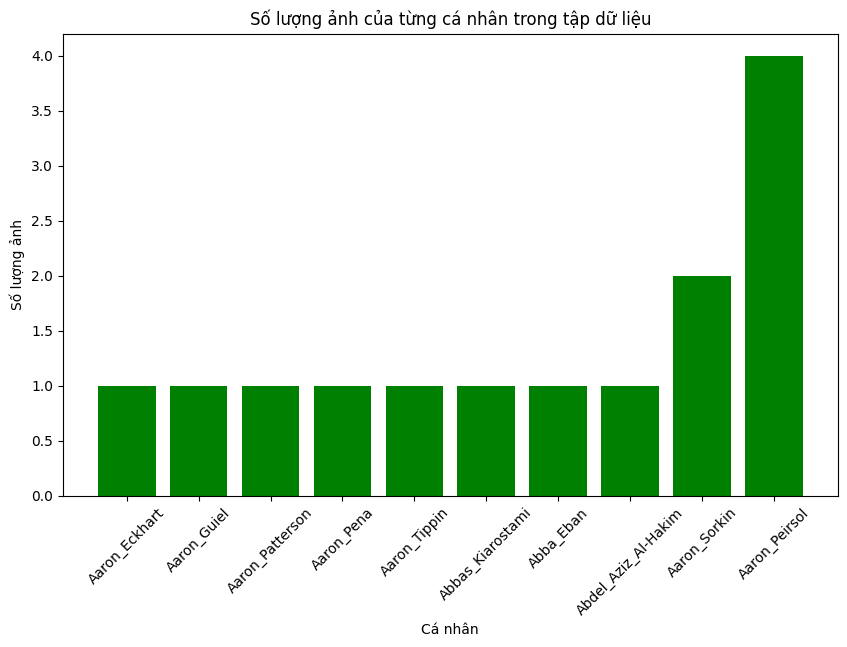

In [12]:
# Danh sách tên và số lượng ảnh
labels = list(class_mapping.values())  
sizes = list(class_images.values()) 

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color="green")  # Dùng màu nhẹ để biểu đồ đẹp hơn
plt.xlabel("Cá nhân")
plt.ylabel("Số lượng ảnh")
plt.title("Số lượng ảnh của từng cá nhân trong tập dữ liệu")
plt.xticks(rotation=45)  # Xoay tên để dễ đọc
plt.show()

(14, 250, 250) (14,)


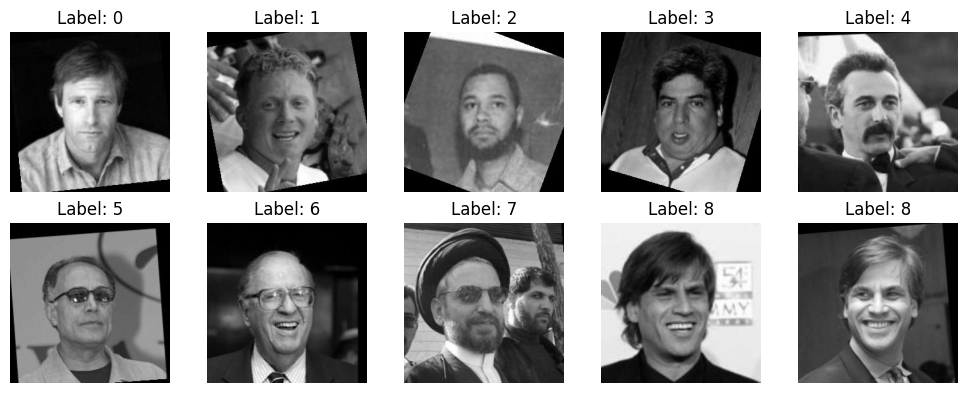

In [13]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Khởi tạo danh sách lưu hình ảnh và nhãn
image_arrays = []
image_labels = []
root_image_directory = "D:/NCKH/data/lfw_filtered"

# Duyệt qua từng cá nhân trong class_mapping
for label, person in class_mapping.items():
    for directory in os.listdir(root_image_directory):
        if directory.split(" ")[1] == person:
            image_directory = os.path.join(root_image_directory, directory)
            break

    for image_name in os.listdir(image_directory):
        image_path = os.path.join(image_directory, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh dưới dạng grayscale
        image_arrays.append(image)
        image_labels.append(label)

# Chuyển danh sách sang NumPy array
image_arrays = np.array(image_arrays)
image_labels = np.array(image_labels)

print(image_arrays.shape, image_labels.shape)

# Hiển thị một số hình ảnh bằng matplotlib
fig, axes = plt.subplots(2, 5, figsize=(10, 4))  # Hiển thị 10 hình ảnh
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(image_arrays[i], cmap="gray")
    axes[i].set_title(f"Label: {image_labels[i]}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [14]:
for directory in os.listdir(root_image_directory):
    person_name = " ".join(directory.split(" ")[1:])
    image_directory = os.path.join(root_image_directory, directory)

    if os.path.exists(image_directory):
        num_images = len(os.listdir(image_directory))
        print(f"{person_name}: {num_images} ảnh")

Aaron_Eckhart: 1 ảnh
Aaron_Guiel: 1 ảnh
Aaron_Patterson: 1 ảnh
Aaron_Pena: 1 ảnh
Aaron_Tippin: 1 ảnh
Abbas_Kiarostami: 1 ảnh
Abba_Eban: 1 ảnh
Abdel_Aziz_Al-Hakim: 1 ảnh
Aaron_Sorkin: 2 ảnh
Aaron_Peirsol: 4 ảnh


In [15]:
import numpy as np
import math
from collections import Counter

# Tỷ lệ phân chia dữ liệu
train_frac = 0.70
valid_frac = 0.05
test_frac = 0.25

# Hàm tạo các tập dữ liệu từ đầu vào ảnh và nhãn
def create_data_splits(X, y, train_frac=train_frac, test_frac=test_frac, valid_frac=valid_frac):
    X = np.array(X)
    y = np.array(y)

    # Kiểm tra tổng các tỷ lệ có bằng 1.0 không
    assert (test_frac + valid_frac + train_frac == 1.0), "Tổng của tỷ lệ Train, Valid, Test phải bằng 1.0"

    # Khởi tạo danh sách rỗng để lưu dữ liệu phân chia
    X_raw_test, X_raw_valid, X_raw_train = [], [], []
    y_raw_test, y_raw_valid, y_raw_train = [], [], []

  

    # Xáo trộn dữ liệu ngẫu nhiên để tránh thứ tự cố định
    random_indices = np.random.permutation(len(X))
    X = X[random_indices]
    y = y[random_indices]

    # Duyệt qua từng ảnh và nhãn để phân chia dữ liệu
    for image, label in zip(X, y):
        test_length = max(1, math.floor(test_frac * class_images[label]))  # Đảm bảo ít nhất có 1 ảnh
        valid_length = max(1, math.floor(valid_frac * class_images[label]))  # Đảm bảo ít nhất có 1 ảnh

        # Kiểm tra số lượng ảnh và phân vào tập dữ liệu tương ứng
        if y_raw_test.count(label) < test_length:
            X_raw_test.append(image)
            y_raw_test.append(label)
        elif y_raw_valid.count(label) < valid_length:
            X_raw_valid.append(image)
            y_raw_valid.append(label)
        else:
            X_raw_train.append(image)
            y_raw_train.append(label)

    # Chuyển đổi danh sách sang NumPy arrays, xử lý trường hợp danh sách rỗng
    X_raw_test = np.array(X_raw_test, dtype=np.float32) if X_raw_test else np.empty((0,) + X.shape[1:], dtype=np.float32)
    y_raw_test = np.array(y_raw_test, dtype=np.int32) if y_raw_test else np.empty((0,), dtype=np.int32)

    X_raw_valid = np.array(X_raw_valid, dtype=np.float32) if X_raw_valid else np.empty((0,) + X.shape[1:], dtype=np.float32)
    y_raw_valid = np.array(y_raw_valid, dtype=np.int32) if y_raw_valid else np.empty((0,), dtype=np.int32)

    X_raw_train = np.array(X_raw_train, dtype=np.float32) if X_raw_train else np.empty((0,) + X.shape[1:], dtype=np.float32)
    y_raw_train = np.array(y_raw_train, dtype=np.int32) if y_raw_train else np.empty((0,), dtype=np.int32)

    return X_raw_train, X_raw_valid, X_raw_test, y_raw_train, y_raw_valid, y_raw_test



# Gọi hàm để phân chia tập dữ liệu
X_train, X_valid, X_test, y_train, y_valid, y_test = create_data_splits(image_arrays, image_labels)

# Kiểm tra kích thước của các tập dữ liệu sau khi phân chia
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(2, 250, 250) (2, 250, 250) (10, 250, 250)
(2,) (2,) (10,)


In [17]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Hàm hiển thị hình ảnh màu
def plot_color_image(image):
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Chuyển từ BGR sang RGB
    plt.axis('off')

# Số ảnh hiển thị cho mỗi lớp
num_examples = 2

# Duyệt qua từng lớp và hiển thị ảnh mẫu
for class_number, person in class_mapping.items():
    print('{} - Số lượng ảnh: {}'.format(person, class_images[class_number]))
    example_images = []
    
    while len(example_images) < num_examples:
        random_index = np.random.randint(len(X_train))
        if y_train[random_index] == class_number:
            example_images.append(X_train[random_index])
    
    # Sử dụng plt.subplots để hiển thị ảnh đúng cách
    fig, axes = plt.subplots(1, num_examples, figsize=(10, 4))

    for i, image in enumerate(example_images):
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Chuyển từ BGR sang RGB
        axes[i].axis('off')

    plt.tight_layout()  # Giúp ảnh hiển thị đẹp hơn
    plt.show()  # Hiển thị hình ảnh

Aaron_Eckhart - Số lượng ảnh: 1


KeyboardInterrupt: 

In [18]:
import cv2
import numpy as np

def prepare_image(image, target_height=299, target_width=299):
    image = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_AREA)
    return image.astype(np.float32) / 255

In [19]:
from nets import inception 
from tensorflow.contrib import slim
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 299, 299, 3], name='X')
is_training = tf.placeholder_with_default(False, [])
# Run inception function to determine endpoints
with slim.arg_scope(inception.inception_v3_arg_scope()):
 logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=is_training)
# Create saver of network before alterations
inception_saver = tf.train.Saver()
print(end_points)

ImportError: cannot import name 'inception' from 'nets' (c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\nets\__init__.py)

trong nets ko có chứa inception.py vì nó thuộc tensorflow ver 1.x đã cũ, hiện đang dùng ver 2.x

In [20]:
from tensorflow.keras.applications import InceptionV3

# Tải mô hình với trọng số đã huấn luyện trên ImageNet
model = InceptionV3(weights='imagenet')

# Xem cấu trúc mô hình
model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 147, 147,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 147, 147,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 71, 71,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 23,851,784 (90.99 MB)

 Trainable params: 23,817,352 (90.86 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [21]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

# Load mô hình
base_model = InceptionV3(weights='imagenet')

# Trích xuất đặc trưng từ lớp cuối cùng
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('mixed10').output)
print("Kích thước đầu ra:", feature_extractor.output.shape)

Kích thước đầu ra: (None, 8, 8, 2048)


Vì sao trích xuất đặc trưng từ lớp cuối cùng là mixed10:
1. đầu ra dạng 8,8,2048, và chứa 2048 đặc trưng mạnh nhất
2. avg_pool không dùng? _ lấy tb từ mixed10, làm phẳng đầu ra mất 8,8_giúp giảm số lượng tham số tránh overfitting
3. tinh chỉnh (fine-tuning) mô hình với CNN nên dùng mixed10


In [22]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np

# 🔹 1️⃣ Tải mô hình InceptionV3 với trọng số từ ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False)

# 🔹 2️⃣ Trích xuất đặc trưng từ lớp cuối cùng (Mixed10)
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('mixed10').output)

# 🔹 3️⃣ Sử dụng GlobalAveragePooling2D để xử lý đầu ra
prelogits = GlobalAveragePooling2D()(feature_extractor.output)  # (None, 2048)

# 🔹 4️⃣ Thêm lớp phân loại mới
n_outputs = 10  # Số lượng lớp phân loại (chỉnh theo dataset của bạn)
people_logits = Dense(n_outputs, activation='softmax', name="people_logits")(prelogits) # lớp cuối cùng là lớp phân loại (Dense), được thêm vào sau khi trích xuất đặc trưng từ mô hình InceptionV3.


# 🔹 5️⃣ Tạo mô hình mới với phần đầu vào giữ nguyên từ InceptionV3
new_model = Model(inputs=base_model.input, outputs=people_logits)

# 🔹 6️⃣ Chỉ huấn luyện lớp cuối cùng
for layer in base_model.layers:
    layer.trainable = False  # Giữ nguyên trọng số của các lớp trước

# 🔹 7️⃣ Cấu hình mô hình
new_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.01),
                  metrics=['accuracy'])

# 🔹 8️⃣ Chuẩn bị dữ liệu huấn luyện (Đảm bảo kiểu dữ liệu đúng)
X_train = X_train.astype(np.float32)
y_train = np.array(y_train, dtype=np.int64)

# 🔹 9️⃣ Huấn luyện mô hình
new_model.fit(X_train, y_train, epochs=10, batch_size=8)

# 🔹 🔟 Lưu mô hình sau khi huấn luyện
new_model.save("fine_tuned_inceptionv3.h5")
print("Đã lưu mô hình thành công! 🚀")

Epoch 1/10


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 250, 250), dtype=float32). Expected shape (None, None, None, 3), but input has incompatible shape (None, 250, 250)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 250, 250), dtype=float32)
  • training=True
  • mask=None

In [23]:
import tensorflow as tf
import time
from datetime import datetime

# Tạo thư mục để lưu logs
now = datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = "{}_unaugmented".format(now)
logdir = "tensorboard/faces/" + model_dir

# Tạo FileWriter mới cho TensorFlow 2.x
file_writer = tf.summary.create_file_writer(logdir)

# Ghi số liệu vào TensorBoard
with file_writer.as_default():
    for step in range(100):  # Giả lập 100 bước huấn luyện
        accuracy_value = 0.85 + step * 0.001  # Giả lập giá trị độ chính xác
        loss_value = 0.4 - step * 0.001  # Giả lập giá trị loss

        tf.summary.scalar("valid_acc", accuracy_value, step=step)
        tf.summary.scalar("valid_loss", loss_value, step=step)
        file_writer.flush()  # Đảm bảo dữ liệu được ghi ngay vào file

tensorboard --logdir=D:/NCKH/tensorboard/faces/20250521_185759_unaugmented
# chạy tensorboard trên web để xem biểu đồ valid_acc, cho thấy độ chính xác xác thực (validation accuracy) của mô hình tăng từ khoảng 0.85 -     ~0.95


In [25]:
import os
import cv2
import numpy as np

data_dir = "D:/NCKH/data/lfw_filtered"
img_size = (299, 299)

X, Y = [], []
label_map = {}  # Lưu ánh xạ tên thư mục thành số lớp

for label, person_folder in enumerate(sorted(os.listdir(data_dir))):
    label_map[label] = person_folder
    folder_path = os.path.join(data_dir, person_folder)
    
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)  # Đọc ảnh
        img = cv2.resize(img, img_size)  # Resize ảnh về (299,299)
        X.append(img)
        Y.append(label)  # Gán nhãn số

# Chuyển về NumPy
X = np.array(X, dtype=np.float32) / 255.0  # Chuẩn hóa về [0,1]
Y = np.array(Y, dtype=np.int32)

print(f"Đã tải {X.shape[0]} ảnh, kích thước mỗi ảnh: {X.shape[1:]}")
print(f"Số lớp: {len(set(Y))}, ánh xạ nhãn: {label_map}")

Đã tải 14 ảnh, kích thước mỗi ảnh: (299, 299, 3)
Số lớp: 10, ánh xạ nhãn: {0: '001 Aaron_Eckhart', 1: '001 Aaron_Guiel', 2: '001 Aaron_Patterson', 3: '001 Aaron_Pena', 4: '001 Aaron_Tippin', 5: '001 Abba_Eban', 6: '001 Abbas_Kiarostami', 7: '001 Abdel_Aziz_Al-Hakim', 8: '002 Aaron_Sorkin', 9: '004 Aaron_Peirsol'}


In [26]:
print(os.listdir("D:/NCKH/data/lfw"))

['lfw-deepfunneled', 'lfw_allnames.csv', 'lfw_readme.csv', 'matchpairsDevTest.csv', 'matchpairsDevTrain.csv', 'mismatchpairsDevTest.csv', 'mismatchpairsDevTrain.csv', 'pairs.csv', 'people.csv', 'peopleDevTest.csv', 'peopleDevTrain.csv']


In [27]:
import tensorflow as tf
import numpy as np
import time
from datetime import datetime

# 🔹 1️⃣ Tạo mô hình InceptionV3
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)

feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('mixed10').output)
prelogits = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor.output)

n_outputs = 10
people_logits = tf.keras.layers.Dense(n_outputs, activation='softmax', name="people_logits")(prelogits)

new_model = tf.keras.Model(inputs=base_model.input, outputs=people_logits)

# 🔹 2️⃣ Chỉ huấn luyện lớp cuối cùng
for layer in base_model.layers:
    layer.trainable = False

# 🔹 3️⃣ Cấu hình mô hình
new_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  metrics=['accuracy'])

# 🔹 4️⃣ Chuẩn bị dữ liệu giả lập
X_train = np.random.rand(100, 299, 299, 3).astype(np.float32)
y_train = np.random.randint(0, n_outputs, 100).astype(np.int32)

# 🔹 5️⃣ Thiết lập TensorBoard
now = datetime.now().strftime("%Y%m%d_%H%M%S")
logdir = f"tensorboard/faces/{now}_unaugmented"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# 🔹 6️⃣ Dừng sớm nếu không cải thiện sau 20 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 🔹 7️⃣ Huấn luyện mô hình
new_model.fit(X_train, y_train, epochs=100, batch_size=32,
              validation_split=0.2,
              callbacks=[tensorboard_callback, early_stopping])

# 🔹 8️⃣ Lưu mô hình sau khi huấn luyện
new_model.save("fine_tuned_inceptionv3.h5")
print("Đã lưu mô hình thành công! 🚀")

Epoch 1/100


OverflowError: Python int too large to convert to C long

tensorboard --logdir=D:\NCKH\tensorboard\faces\20250521_191425_unaugmented\train

In [28]:
import scipy
# Take in an image as an array and return image with a [dx, dy] shift
def shift_image(image_array, shift):
 return scipy.ndimage.interpolation.shift(image_array, shift, cval=0)
# Four shifts of 30 pixels 
shifts = [[30,0], [-30,0], [0, 30], [0,-30]]
shifted_images = []
shifted_labels = []
# Iterate through all training images
for image, label in zip(X_train, y_train):
 
 # Swap the color channel and height axis 
 layers = np.swapaxes(image, 0, 2)
 
 # Apply four shifts to each original image
 for shift in shifts:
    transposed_image_layers = []
 
 # Apply the shift to the image one layer at a time
 # Each layer is an RGB color channel
 for layer in layers:
    transposed_image_layers.append(shift_image(layer, shift))
 
 # Stack the RGB layers to get one image and reswap the axes
 transposed_image = np.stack(transposed_image_layers)
 transposed_image = np.swapaxes(transposed_image, 0, 2)
 
 # Add the shifted images and the labels to a list
 shifted_images.append(transposed_image)
 shifted_labels.append(label)
# Convert the images and labels to numpy arrays
shifted_images = np.array(shifted_images)
shifted_labels = np.array(shifted_labels)
print(shifted_images.shape,shifted_labels.shape)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14716\3173237373.py:4: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  return scipy.ndimage.interpolation.shift(image_array, shift, cval=0)


(100, 299, 299, 3) (100,)


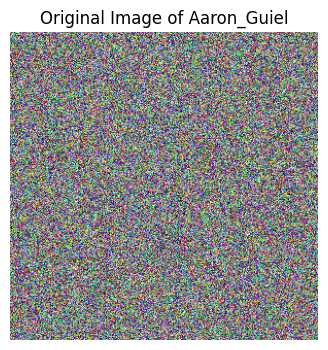

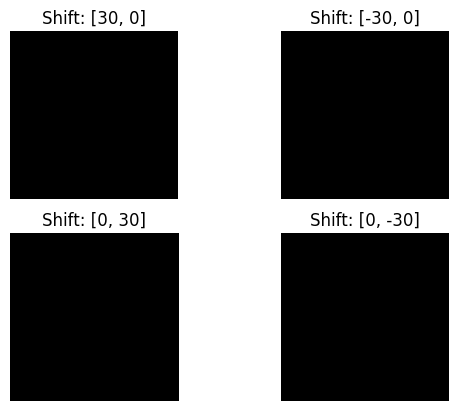

In [30]:
ex_index = 5
# Plot original image
plot_color_image(X_train[ex_index])
plt.title("Original Image of {}".format(class_mapping[y_train[ex_index]]))
plt.show()
ex_shifted_images = shifted_images[ex_index*4:(ex_index*4)+ 4]
# Plot four shifted images
for i, image in enumerate(ex_shifted_images):
 shift = shifts[i]
 plt.subplot(2,2,i+1)
 plt.imshow(image.astype(np.uint8), interpolation='nearest')
 plt.title('Shift: {}'.format(shift))
 plt.axis('off')
plt.show()

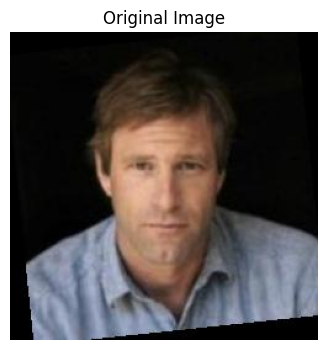

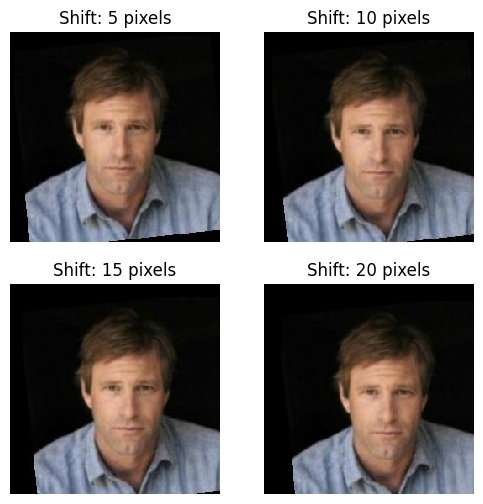

In [31]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Đọc ảnh bằng OpenCV
ex_index = 5
image_path = r"D:\NCKH\data\lfw_filtered\001 Aaron_Eckhart\Aaron_Eckhart_0001.jpg"  # Thay đường dẫn ảnh của bạn
original_image = cv2.imread(image_path)  # Đọc ảnh
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB để hiển thị đúng màu với Matplotlib

# Hiển thị ảnh gốc
plt.figure(figsize=(4,4))
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Tạo một số biến đổi hình ảnh để mô phỏng hiệu ứng shift
ex_shifted_images = [cv2.warpAffine(original_image, np.float32([[1, 0, shift], [0, 1, shift]]), (original_image.shape[1], original_image.shape[0])) for shift in [5, 10, 15, 20]]

# Hiển thị các ảnh đã dịch chuyển
plt.figure(figsize=(6,6))
for i, image in enumerate(ex_shifted_images):
    shift = [5, 10, 15, 20][i]  # Độ dịch chuyển
    plt.subplot(2, 2, i+1)
    plt.imshow(image.astype(np.uint8), interpolation='nearest')
    plt.title(f'Shift: {shift} pixels')
    plt.axis('off')

plt.show()

In [32]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (100, 299, 299, 3)
y_train shape: (100,)


In [33]:
# Create a new training set with the original and shifted images
X_train_exp = np.concatenate((shifted_images, X_train))
y_train_exp = np.concatenate((shifted_labels, y_train))
print(X_train_exp.shape, y_train_exp.shape)

(200, 299, 299, 3) (200,)


In [47]:
import os
print(os.path.exists(image_path))  # Kiểm tra xem tệp có tồn tại không

False


In [42]:
images_flipped = []
labels_flipped = []
# Flip every image in the training set
for image, label in zip(X_train, y_train):
 images_flipped.append(np.fliplr(image))
 labels_flipped.append(label)
# Convert the flipped images and labels to arrays
images_flipped = np.array(images_flipped)
labels_flipped = np.array(labels_flipped)

In [43]:
print("Số ảnh trong X_train:", len(X_train))

Số ảnh trong X_train: 100


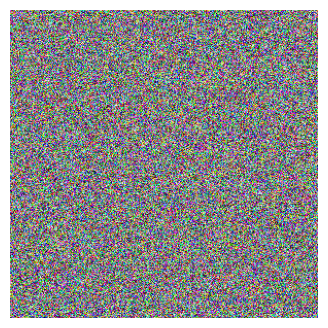

In [34]:
import random
ex_index = random.randint(0, len(X_train) - 1)
plot_color_image(X_train[ex_index])

In [36]:
ex_index = 652
plot_color_image(X_train[ex_index])
plt.title('Original Image of {}'.format(class_mapping[y_train[ex_index]]))
plt.show()
plot_color_image(images_flipped[ex_index])
plt.title('Left to Right Flipped Image')
plt.show()

IndexError: index 652 is out of bounds for axis 0 with size 100

In [94]:
X_train_with_flip = np.concatenate((X_train, images_flipped))
y_train_with_flip = np.concatenate((y_train, labels_flipped))
print(X_train_with_flip.shape, y_train_with_flip.shape)

(200, 299, 299, 3) (200,)


In [37]:
print(globals().keys())  # Xem các biến đã có trong chương trình

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '_i', '_ii', '_iii', '_i1', 'os', 'np', 'plt', 'tf', 'ImageDataGenerator', 'InceptionV3', 'preprocess_input', 'layers', 'models', 'cosine_similarity', 'LabelEncoder', 'urllib', 'random', 'tarfile', 'zipfile', 'slim', '_i2', 'INCEPTION_V3_URL', 'MODEL_DIR', 'filename', 'filepath', '_i3', '_i4', 'file_path', 'extract_path', 'zip_ref', '_i5', 'Image', 'model', 'load_and_preprocess_image', '_i6', 'lfw_folder', '_i7', 'people', 'people_number', 'person', 'person_folder', 'num_images', 'people_with_one_photo', '_i8', 'copy_tree', 'num_classes', 'IMAGES_DOWNLOAD_DIRECTORY', 'IMAGES_DIRECTORY', 'name', 'folder_path', 'formatted_num_images', 'new_folder_name', 'image_new_name', 'dst_folder', '_i9', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', 'class_map

In [41]:
def classify_image(index, images=X_test, labels=y_test):
     image_array = images[index]
label = class_mapping[labels[index]]
 
prepared_image = prepare_image(image_array)
prepared_image = np.reshape(prepared_image, newshape=(-1, 299, 299, 3))
 
with tf.Session() as sess:
    saver.restore(sess, restart_augmented_training_path)
predictions = sess.run(probability, {X: prepared_image})
 
predictions = [(i, prediction) for i, prediction in enumerate(predictions[0])]
predictions = sorted(predictions, key=lambda x: x[1], reverse=True)
print('\nCorrect Answer: {}'.format(label)) 
print('\nPredictions:')
for prediction in predictions:
    class_label = prediction[0]
probability_value = prediction[1]
label = class_mapping[class_label]
print("{:26}: {:.2f}%".format(label, probability_value * 100))
 
plot_color_image(image_array)
return predictions

KeyError: 'Aaron_Peirsol'